In [2]:
import logging

import pandas as pd
import skorch
import torch
from braindecode import EEGClassifier
from braindecode.datautil.mne import create_from_mne_epochs
from braindecode.models import EEGNetv4
from braindecode.util import set_random_seeds
from matplotlib import pyplot as plt
import os.path
import scipy.io
import numpy as np
import mne
import pyxdf
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split

from skorch.callbacks import Checkpoint
from skorch.helper import predefined_split
from torch import Tensor

c:\toolboxes\github\bci4als-mi\venv\lib\site-packages\braindecode\datautil\mne.py:8: UserWarning: datautil.mne module is deprecated and is now under datasets.mne, please use from import braindecode.datasets.mne
  warn('datautil.mne module is deprecated and is now under '


In [11]:

def read_matlab_mat_to_np(filename, data_index=3):
    """
    Read a nummpy array from a matlab matrix file (.mat)
    :param filename: Matlab Matrix Filename (.mat file)
    :param data_index: Top level index of the data to be fetched. default is 3.
    :return:
    """
    # try:
    mat = scipy.io.loadmat(filename)
    return np.array(mat[list(mat.keys())[data_index]])

In [17]:
RECORDINGS_DIR = 'C:\Recordings'

# RECORDING_FOLDER = "SubAH2021-11-28"
RECORDING_FOLDER = 'Other Teams\Team32ForTest'

In [38]:
fname = f"{RECORDINGS_DIR}/{RECORDING_FOLDER}/EEG.xdf"
streams, headers = pyxdf.load_xdf(fname)
data = streams[0]['time_series']
data *= 1e-6

In [39]:
stim = np.zeros(len(data))
trial_started = False
trial_type = 0
for timestamp, marker in zip(streams[1]['time_stamps'], streams[1]['time_series']):
    # marker = int(float(marker[0]))
    # if marker == 1111:
    #     trial_started = True
    # if marker in [1, 2, 3]:
    #     trial_type = marker
    # if marker == 9:
    #     trial_started = False
    # if trial_started:
    index = np.where(np.isclose(streams[0]['time_stamps'], timestamp, rtol=0, atol=0.01))
    # assert np.array(index).any()
    # if len(index):
    #     index = index[0]
    stim[index] = marker

In [40]:
data = np.hstack([data, stim.reshape(-1, 1)]).T

In [8]:
%matplotlib

Using matplotlib backend: <object object at 0x00000171956AF350>


In [41]:
ch_names = read_matlab_mat_to_np(f"{RECORDINGS_DIR}/{RECORDING_FOLDER}/EEG_chans.mat")
info = mne.create_info(sfreq=125, ch_names=[name for name in ch_names]+["stim"], ch_types=['eeg']*16 + ["stim"])
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=17, n_times=24870
    Range : 0 ... 24869 =      0.000 ...   198.952 secs
Ready.


<ipython-input-41-a9047e0ea896>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'P03'}. Applying running numbers for duplicates.
  info = mne.create_info(sfreq=125, ch_names=[name for name in ch_names]+["stim"], ch_types=['eeg']*16 + ["stim"])


In [23]:
event_dict = {"Right": 2, "Left": 1, "Idle": 3}
events = mne.find_events(raw, stim_channel="stim", output="onset", shortest_event=0)
raw.drop_channels(["stim", "P03-0", "P03-2", "P03-1"])

92 events found
Event IDs: [   1    2    3    9   99 1001 1111]


<RawArray | 13 x 24870 (199.0 s), ~2.5 MB, data loaded>

Channels marked as bad: ['O02', 'P03-0', 'P03-1', 'P03-2', 'O01', 'Fc5']


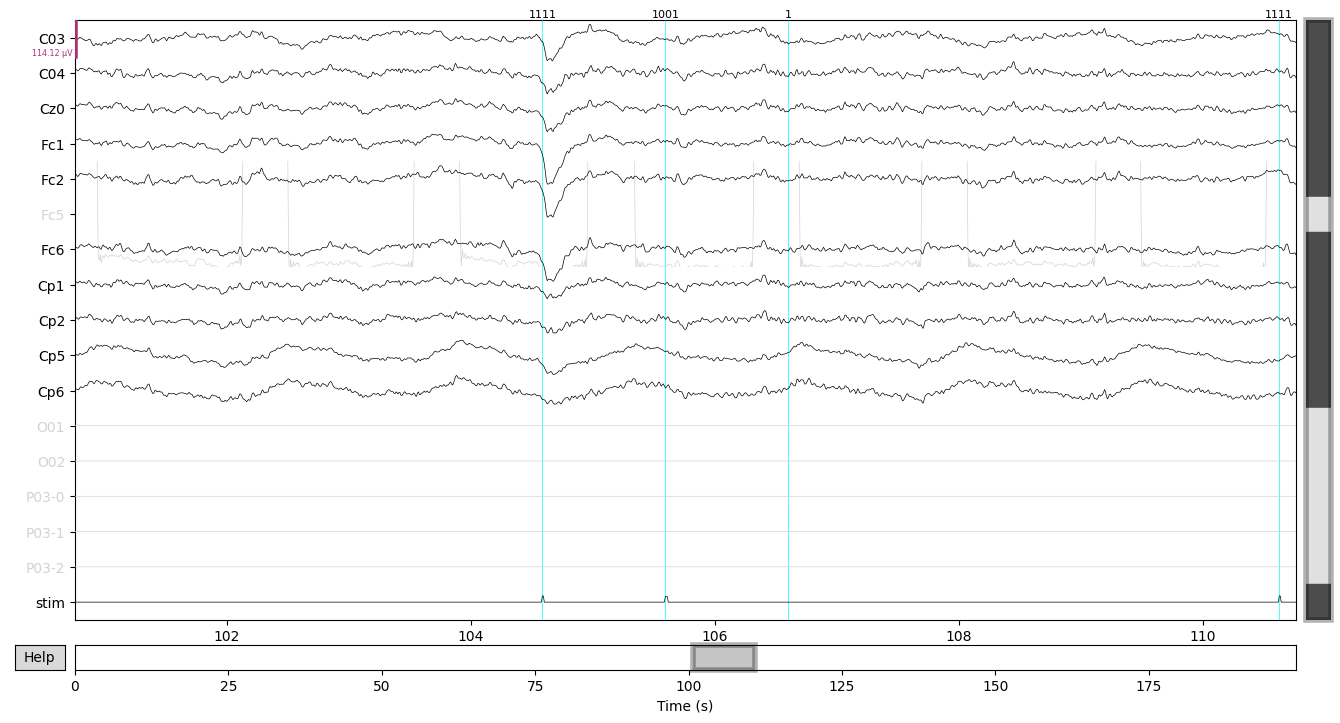

In [48]:
raw.plot(events, block=True)

In [47]:
raw.plot_psd(show=False)
plt.show(block=True)

Effective window size : 16.384 (s)


<ipython-input-47-e9b80891bb9e>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(show=False)


In [46]:
raw.filter(l_freq=0.5, h_freq=40)
raw.notch_filter(50, picks=['eeg'])


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (6.600 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth

<RawArray | 17 x 24870 (199.0 s), ~3.2 MB, data loaded>

Channels marked as bad: ['O02', 'P03-0', 'P03-1', 'P03-2', 'O01', 'Fc5']


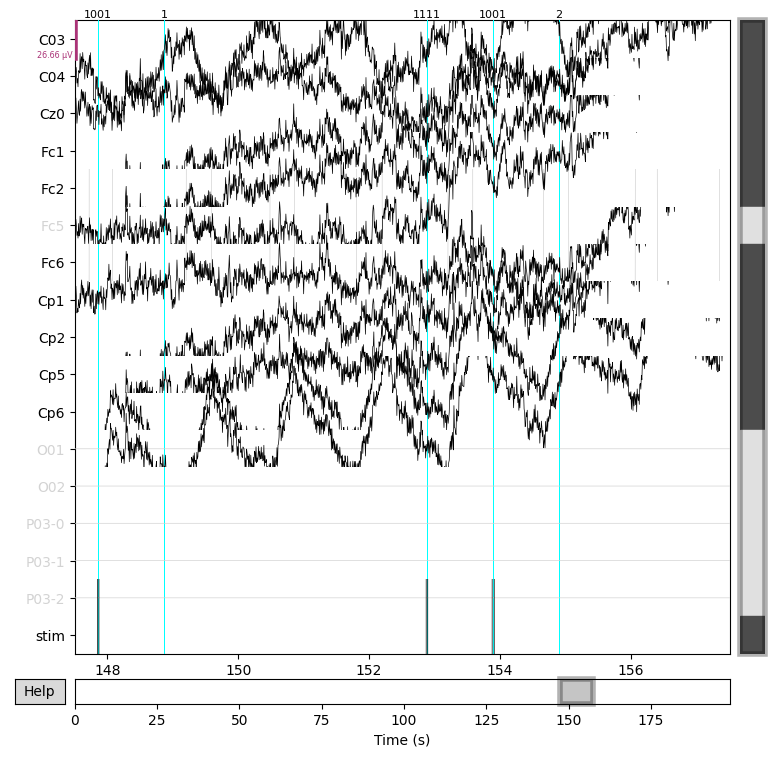

In [44]:
raw.plot(block=True, events=events, scalings='auto')


In [12]:
epochs = mne.Epochs(raw, events, picks=['eeg'], tmin=-0.1, tmax=5,
                                 event_id=event_dict, verbose='INFO')

Not setting metadata
Not setting metadata
30 matching events found
Setting baseline interval to [-0.096, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [13]:
epochs["Idle"].plot_image(picks=['C04'], show=False)
plt.show(block=True)


Loading data for 10 events and 638 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-13-0b0c8bc2f040>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs["Idle"].plot_image(picks=['C04'], show=False)


In [14]:
old_level = mne.set_log_level(logging.FATAL, return_old_level=True)

epochs.events[:, 2][epochs.events[:, 2] == 3] = 0
windows_datasets = create_from_mne_epochs(
            [epochs],
            window_size_samples=epochs[0].get_data().shape[2],
            window_stride_samples=epochs[0].get_data().shape[2],
            drop_last_window=True
        )
mne.set_log_level(old_level)

Loading data for 1 events and 638 original time points ...
0 bad epochs dropped
Loading data for 1 events and 638 original time points ...
0 bad epochs dropped


In [15]:
indices = np.arange(0, len(windows_datasets.description))
train_indices, test_indices = train_test_split(indices, train_size=0.7)

splitted = windows_datasets.split(by=[list(train_indices), list(test_indices)])
train_indices = train_indices
test_indices = test_indices
train_set = splitted['0']
valid_set = splitted['1']
windows_dataset = windows_datasets

In [16]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20211128  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 3
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]
F1 = 2
D = 2
model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    kernel_length=125 // 2,
    F1=F1,
    D=D,
)
# Send model to GPU
if cuda:
    model.cuda()
__device = device
model = model

Loading data for 1 events and 638 original time points ...
Loading data for 1 events and 638 original time points ...


In [29]:
class Criterion(torch.nn.NLLLoss):

    def __init__(self):
        super(Criterion, self).__init__()

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        # print("input", input, sep='\n')
        target[target == 3] = 0
        # print("target", target, sep='\n')
        return super(Criterion, self).forward(input, target)

lr = 0.1 * 0.0001

batch_size = 2

In [30]:
checkpoint_dir = f'checkpoints'
chkpnt = Checkpoint(
    monitor='valid_balanced_accuracy_best',
    f_params="params{last_epoch[epoch]}.pt",
    f_optimizer="optimizer{last_epoch[epoch]}.pt",
    f_criterion="criterion{last_epoch[epoch]}.pt",
    f_history="history.json",
    dirname=checkpoint_dir
)
callbacks = [
    "accuracy", "balanced_accuracy", ("checkpoint", chkpnt),
    ("progress", skorch.callbacks.ProgressBar(detect_notebook=True))]

In [31]:
classifier = EEGClassifier(
            model,
            criterion=Criterion,
            optimizer=torch.optim.Adam,
            train_split=predefined_split(valid_set),  # using valid_set for validation
            optimizer__lr=lr,
            batch_size=batch_size,
            callbacks=callbacks,
            device=__device,
        )

In [32]:
old_level = mne.set_log_level(logging.FATAL, return_old_level=True)
y = [dataset.y for dataset in train_set.datasets]
classifier.fit(train_set, y=None, epochs=300)
mne.set_log_level(old_level)

  0%|          | 0/16 [00:00<?, ?it/s]

  epoch    train_accuracy    train_balanced_accuracy    train_loss    valid_accuracy    valid_balanced_accuracy    valid_loss    cp     dur
-------  ----------------  -------------------------  ------------  ----------------  -------------------------  ------------  ----  ------
      1            1.0000                     1.0000        0.2846            0.5556                     0.6667        8.1840     +  0.4286


  0%|          | 0/16 [00:00<?, ?it/s]

      2            1.0000                     1.0000        0.2428            0.5556                     0.6667        8.1730        0.4685


  0%|          | 0/16 [00:00<?, ?it/s]

      3            1.0000                     1.0000        0.2862            0.5556                     0.6667        8.2811        1.1540


  0%|          | 0/16 [00:00<?, ?it/s]

      4            1.0000                     1.0000        0.2428            0.5556                     0.6667        8.2981        1.1110


  0%|          | 0/16 [00:00<?, ?it/s]

      5            1.0000                     1.0000        0.2894            0.5556                     0.6667        8.3178        1.0080


  0%|          | 0/16 [00:00<?, ?it/s]

      6            1.0000                     1.0000        0.2217            0.5556                     0.6667        8.3400        0.8828


  0%|          | 0/16 [00:00<?, ?it/s]

      7            1.0000                     1.0000        0.2383            0.5556                     0.6667        8.3586        0.6390


  0%|          | 0/16 [00:00<?, ?it/s]

      8            1.0000                     1.0000        0.2910            0.5556                     0.6667        8.3536        0.2941


  0%|          | 0/16 [00:00<?, ?it/s]

      9            1.0000                     1.0000        0.3193            0.5556                     0.6667        8.3473        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

     10            1.0000                     1.0000        0.2481            0.5556                     0.6667        8.3273        0.3400


  0%|          | 0/16 [00:00<?, ?it/s]

     11            1.0000                     1.0000        0.2477            0.5556                     0.6667        8.3321        0.3630


  0%|          | 0/16 [00:00<?, ?it/s]

     12            1.0000                     1.0000        0.3079            0.5556                     0.6667        8.3663        0.5381


  0%|          | 0/16 [00:00<?, ?it/s]

     13            1.0000                     1.0000        0.2505            0.5556                     0.6667        8.3415        0.3400


  0%|          | 0/16 [00:00<?, ?it/s]

     14            1.0000                     1.0000        0.3404            0.5556                     0.6667        8.3788        0.2870


  0%|          | 0/16 [00:00<?, ?it/s]

     15            1.0000                     1.0000        0.3468            0.5556                     0.6667        8.4447        0.2750


  0%|          | 0/16 [00:00<?, ?it/s]

     16            1.0000                     1.0000        0.2349            0.5556                     0.6667        8.5014        0.2680


  0%|          | 0/16 [00:00<?, ?it/s]

     17            1.0000                     1.0000        0.3140            0.5556                     0.6667        8.4719        0.2855


  0%|          | 0/16 [00:00<?, ?it/s]

     18            1.0000                     1.0000        0.2270            0.5556                     0.6667        8.4763        0.2820


  0%|          | 0/16 [00:00<?, ?it/s]

     19            1.0000                     1.0000        0.1844            0.5556                     0.6667        8.4707        0.4115


  0%|          | 0/16 [00:00<?, ?it/s]

     20            1.0000                     1.0000        0.2470            0.5556                     0.6667        8.4549        0.3740


  0%|          | 0/16 [00:00<?, ?it/s]

     21            1.0000                     1.0000        0.2734            0.5556                     0.6667        8.5046        0.4021


  0%|          | 0/16 [00:00<?, ?it/s]

     22            1.0000                     1.0000        0.2625            0.5556                     0.6667        8.5104        0.3210


  0%|          | 0/16 [00:00<?, ?it/s]

     23            1.0000                     1.0000        0.3001            0.5556                     0.6667        8.5297        0.4060


  0%|          | 0/16 [00:00<?, ?it/s]

     24            1.0000                     1.0000        0.1910            0.5556                     0.6667        8.6197        0.5320


  0%|          | 0/16 [00:00<?, ?it/s]

     25            1.0000                     1.0000        0.2208            0.5556                     0.6667        8.6053        0.3065


  0%|          | 0/16 [00:00<?, ?it/s]

     26            1.0000                     1.0000        0.2660            0.5556                     0.6667        8.5860        0.2760


  0%|          | 0/16 [00:00<?, ?it/s]

     27            1.0000                     1.0000        0.3321            0.5556                     0.6667        8.6064        0.3650


  0%|          | 0/16 [00:00<?, ?it/s]

     28            1.0000                     1.0000        0.2695            0.5556                     0.6667        8.6119        0.3290


  0%|          | 0/16 [00:00<?, ?it/s]

     29            1.0000                     1.0000        0.2150            0.5556                     0.6667        8.5662        0.5185


  0%|          | 0/16 [00:00<?, ?it/s]

     30            1.0000                     1.0000        0.3529            0.5556                     0.6667        8.5909        0.4315


  0%|          | 0/16 [00:00<?, ?it/s]

     31            1.0000                     1.0000        0.2037            0.5556                     0.6667        8.6480        0.4310


  0%|          | 0/16 [00:00<?, ?it/s]

     32            1.0000                     1.0000        0.2420            0.5556                     0.6667        8.6211        0.3875


  0%|          | 0/16 [00:00<?, ?it/s]

     33            1.0000                     1.0000        0.1946            0.5556                     0.6667        8.6243        0.3490


  0%|          | 0/16 [00:00<?, ?it/s]

     34            1.0000                     1.0000        0.1924            0.5556                     0.6667        8.6545        0.3430


  0%|          | 0/16 [00:00<?, ?it/s]

     35            1.0000                     1.0000        0.2933            0.5556                     0.6667        8.6822        0.3025


  0%|          | 0/16 [00:00<?, ?it/s]

     36            1.0000                     1.0000        0.2101            0.5556                     0.6667        8.6836        0.5061


  0%|          | 0/16 [00:00<?, ?it/s]

     37            1.0000                     1.0000        0.2407            0.5556                     0.6667        8.6592        0.3390


  0%|          | 0/16 [00:00<?, ?it/s]

     38            1.0000                     1.0000        0.2690            0.5556                     0.6667        8.6696        0.3875


  0%|          | 0/16 [00:00<?, ?it/s]

     39            1.0000                     1.0000        0.1750            0.5556                     0.6667        8.6105        0.3120


  0%|          | 0/16 [00:00<?, ?it/s]

     40            1.0000                     1.0000        0.2653            0.5556                     0.6667        8.5655        0.4935


  0%|          | 0/16 [00:00<?, ?it/s]

     41            1.0000                     1.0000        0.2806            0.5556                     0.6667        8.5550        0.2780


  0%|          | 0/16 [00:00<?, ?it/s]

     42            1.0000                     1.0000        0.2450            0.5556                     0.6667        8.5814        0.3490


  0%|          | 0/16 [00:00<?, ?it/s]

     43            1.0000                     1.0000        0.2760            0.5556                     0.6667        8.6637        0.4075


  0%|          | 0/16 [00:00<?, ?it/s]

     44            1.0000                     1.0000        0.2444            0.5556                     0.6667        8.7725        0.3750


  0%|          | 0/16 [00:00<?, ?it/s]

     45            1.0000                     1.0000        0.2412            0.5556                     0.6667        8.7496        0.6704


  0%|          | 0/16 [00:00<?, ?it/s]

     46            1.0000                     1.0000        0.2332            0.5556                     0.6667        8.7686        0.5346


  0%|          | 0/16 [00:00<?, ?it/s]

     47            1.0000                     1.0000        0.2971            0.5556                     0.6667        8.7210        0.3820


  0%|          | 0/16 [00:00<?, ?it/s]

     48            1.0000                     1.0000        0.2171            0.5556                     0.6667        8.7300        0.5510


  0%|          | 0/16 [00:00<?, ?it/s]

     49            1.0000                     1.0000        0.2343            0.5556                     0.6667        8.7180        0.4030


  0%|          | 0/16 [00:00<?, ?it/s]

     50            1.0000                     1.0000        0.2126            0.5556                     0.6667        8.7252        0.2820


  0%|          | 0/16 [00:00<?, ?it/s]

     51            1.0000                     1.0000        0.2626            0.5556                     0.6667        8.7192        0.2780


  0%|          | 0/16 [00:00<?, ?it/s]

     52            1.0000                     1.0000        0.2872            0.5556                     0.6667        8.7204        0.2705


  0%|          | 0/16 [00:00<?, ?it/s]

     53            1.0000                     1.0000        0.2351            0.5556                     0.6667        8.6954        0.2700


  0%|          | 0/16 [00:00<?, ?it/s]

     54            1.0000                     1.0000        0.2899            0.5556                     0.6667        8.7012        0.2560


  0%|          | 0/16 [00:00<?, ?it/s]

     55            1.0000                     1.0000        0.2483            0.5556                     0.6667        8.6802        0.2710


  0%|          | 0/16 [00:00<?, ?it/s]

     56            1.0000                     1.0000        0.2685            0.5556                     0.6667        8.7210        0.2950


  0%|          | 0/16 [00:00<?, ?it/s]

     57            1.0000                     1.0000        0.2279            0.5556                     0.6667        8.7224        0.3150


  0%|          | 0/16 [00:00<?, ?it/s]

     58            1.0000                     1.0000        0.2773            0.5556                     0.6667        8.6854        0.2790


  0%|          | 0/16 [00:00<?, ?it/s]

     59            1.0000                     1.0000        0.1966            0.5556                     0.6667        8.7123        0.3075


  0%|          | 0/16 [00:00<?, ?it/s]

     60            1.0000                     1.0000        0.2812            0.5556                     0.6667        8.6801        0.3100


  0%|          | 0/16 [00:00<?, ?it/s]

     61            1.0000                     1.0000        0.2879            0.5556                     0.6667        8.6955        0.2900


  0%|          | 0/16 [00:00<?, ?it/s]

     62            1.0000                     1.0000        0.1760            0.5556                     0.6667        8.6893        0.2925


  0%|          | 0/16 [00:00<?, ?it/s]

     63            1.0000                     1.0000        0.2834            0.5556                     0.6667        8.6984        0.2810


  0%|          | 0/16 [00:00<?, ?it/s]

     64            1.0000                     1.0000        0.3498            0.5556                     0.6667        8.7702        0.2880


  0%|          | 0/16 [00:00<?, ?it/s]

     65            1.0000                     1.0000        0.2516            0.5556                     0.6667        8.7620        0.2710


  0%|          | 0/16 [00:00<?, ?it/s]

     66            1.0000                     1.0000        0.2350            0.5556                     0.6667        8.7664        0.2910


  0%|          | 0/16 [00:00<?, ?it/s]

     67            1.0000                     1.0000        0.2716            0.5556                     0.6667        8.8374        0.2690


  0%|          | 0/16 [00:00<?, ?it/s]

     68            1.0000                     1.0000        0.3171            0.5556                     0.6667        8.8273        0.2680


  0%|          | 0/16 [00:00<?, ?it/s]

     69            1.0000                     1.0000        0.2681            0.5556                     0.6667        8.8730        0.2910


  0%|          | 0/16 [00:00<?, ?it/s]

     70            1.0000                     1.0000        0.2861            0.5556                     0.6667        8.9231        0.2845


  0%|          | 0/16 [00:00<?, ?it/s]

     71            1.0000                     1.0000        0.1931            0.5556                     0.6667        8.8908        0.3260


  0%|          | 0/16 [00:00<?, ?it/s]

     72            1.0000                     1.0000        0.2166            0.5556                     0.6667        8.9027        0.3151


  0%|          | 0/16 [00:00<?, ?it/s]

     73            1.0000                     1.0000        0.2556            0.5556                     0.6667        8.9128        0.2945


  0%|          | 0/16 [00:00<?, ?it/s]

     74            1.0000                     1.0000        0.2446            0.5556                     0.6667        8.9502        0.2850


  0%|          | 0/16 [00:00<?, ?it/s]

     75            1.0000                     1.0000        0.2296            0.5556                     0.6667        8.9557        0.2690


  0%|          | 0/16 [00:00<?, ?it/s]

     76            1.0000                     1.0000        0.2748            0.5556                     0.6667        8.9228        0.2900


  0%|          | 0/16 [00:00<?, ?it/s]

     77            1.0000                     1.0000        0.2050            0.5556                     0.6667        8.8998        0.3365


  0%|          | 0/16 [00:00<?, ?it/s]

     78            1.0000                     1.0000        0.2402            0.5556                     0.6667        8.9670        0.2720


  0%|          | 0/16 [00:00<?, ?it/s]

     79            1.0000                     1.0000        0.2118            0.5556                     0.6667        8.9339        0.3170


  0%|          | 0/16 [00:00<?, ?it/s]

     80            1.0000                     1.0000        0.2852            0.5556                     0.6667        8.9271        0.3614


  0%|          | 0/16 [00:00<?, ?it/s]

     81            1.0000                     1.0000        0.2330            0.5556                     0.6667        8.9329        0.3378


  0%|          | 0/16 [00:00<?, ?it/s]

     82            1.0000                     1.0000        0.2863            0.5556                     0.6667        9.0106        0.3413


  0%|          | 0/16 [00:00<?, ?it/s]

     83            1.0000                     1.0000        0.2744            0.5556                     0.6667        9.0141        0.3442


  0%|          | 0/16 [00:00<?, ?it/s]

     84            1.0000                     1.0000        0.2750            0.5556                     0.6667        9.0082        0.3748


  0%|          | 0/16 [00:00<?, ?it/s]

     85            1.0000                     1.0000        0.2272            0.5556                     0.6667        9.0044        0.3263


  0%|          | 0/16 [00:00<?, ?it/s]

     86            1.0000                     1.0000        0.1848            0.5556                     0.6667        8.9803        0.3568


  0%|          | 0/16 [00:00<?, ?it/s]

     87            1.0000                     1.0000        0.2148            0.5556                     0.6667        8.9560        0.3418


  0%|          | 0/16 [00:00<?, ?it/s]

     88            1.0000                     1.0000        0.2674            0.5556                     0.6667        8.9457        0.3501


  0%|          | 0/16 [00:00<?, ?it/s]

     89            1.0000                     1.0000        0.3179            0.5556                     0.6667        8.9748        0.3362


  0%|          | 0/16 [00:00<?, ?it/s]

     90            1.0000                     1.0000        0.2278            0.5556                     0.6667        9.0072        0.3362


  0%|          | 0/16 [00:00<?, ?it/s]

     91            1.0000                     1.0000        0.2917            0.5556                     0.6667        9.0781        0.3463


  0%|          | 0/16 [00:00<?, ?it/s]

     92            1.0000                     1.0000        0.2998            0.5556                     0.6667        9.1020        0.3608


  0%|          | 0/16 [00:00<?, ?it/s]

     93            1.0000                     1.0000        0.2519            0.5556                     0.6667        9.1083        0.3578


  0%|          | 0/16 [00:00<?, ?it/s]

     94            1.0000                     1.0000        0.2433            0.5556                     0.6667        9.0506        0.3598


  0%|          | 0/16 [00:00<?, ?it/s]

     95            1.0000                     1.0000        0.2373            0.5556                     0.6667        9.0711        0.3578


  0%|          | 0/16 [00:00<?, ?it/s]

     96            1.0000                     1.0000        0.2672            0.5556                     0.6667        9.1132        0.4163


  0%|          | 0/16 [00:00<?, ?it/s]

     97            1.0000                     1.0000        0.3475            0.5556                     0.6667        9.1726        0.3553


  0%|          | 0/16 [00:00<?, ?it/s]

     98            1.0000                     1.0000        0.2960            0.5556                     0.6667        9.1126        0.3166


  0%|          | 0/16 [00:00<?, ?it/s]

     99            1.0000                     1.0000        0.3024            0.5556                     0.6667        9.0904        0.3320


  0%|          | 0/16 [00:00<?, ?it/s]

    100            1.0000                     1.0000        0.2560            0.5556                     0.6667        9.1557        0.3071


  0%|          | 0/16 [00:00<?, ?it/s]

    101            1.0000                     1.0000        0.2111            0.5556                     0.6667        9.1629        0.3120


  0%|          | 0/16 [00:00<?, ?it/s]

    102            1.0000                     1.0000        0.2751            0.5556                     0.6667        9.1748        0.3360


  0%|          | 0/16 [00:00<?, ?it/s]

    103            1.0000                     1.0000        0.2246            0.5556                     0.6667        9.2107        0.3456


  0%|          | 0/16 [00:00<?, ?it/s]

    104            1.0000                     1.0000        0.2451            0.5556                     0.6667        9.2067        0.3546


  0%|          | 0/16 [00:00<?, ?it/s]

    105            1.0000                     1.0000        0.2154            0.5556                     0.6667        9.1751        0.3359


  0%|          | 0/16 [00:00<?, ?it/s]

    106            1.0000                     1.0000        0.2318            0.5556                     0.6667        9.1711        0.4013


  0%|          | 0/16 [00:00<?, ?it/s]

    107            1.0000                     1.0000        0.2796            0.5556                     0.6667        9.1749        0.3498


  0%|          | 0/16 [00:00<?, ?it/s]

    108            1.0000                     1.0000        0.1938            0.5556                     0.6667        9.1664        0.4298


  0%|          | 0/16 [00:00<?, ?it/s]

    109            1.0000                     1.0000        0.2442            0.5556                     0.6667        9.1630        0.3508


  0%|          | 0/16 [00:00<?, ?it/s]

    110            1.0000                     1.0000        0.2692            0.5556                     0.6667        9.1482        0.3483


  0%|          | 0/16 [00:00<?, ?it/s]

    111            1.0000                     1.0000        0.2015            0.5556                     0.6667        9.1579        0.3502


  0%|          | 0/16 [00:00<?, ?it/s]

    112            1.0000                     1.0000        0.2371            0.5556                     0.6667        9.1762        0.3568


  0%|          | 0/16 [00:00<?, ?it/s]

    113            1.0000                     1.0000        0.2613            0.5556                     0.6667        9.1682        0.3578


  0%|          | 0/16 [00:00<?, ?it/s]

    114            1.0000                     1.0000        0.2557            0.5556                     0.6667        9.1741        0.3552


  0%|          | 0/16 [00:00<?, ?it/s]

    115            1.0000                     1.0000        0.2746            0.5556                     0.6667        9.1924        0.3213


  0%|          | 0/16 [00:00<?, ?it/s]

    116            1.0000                     1.0000        0.2312            0.5556                     0.6667        9.2074        0.3173


  0%|          | 0/16 [00:00<?, ?it/s]

    117            1.0000                     1.0000        0.2613            0.5556                     0.6667        9.2895        0.3412


  0%|          | 0/16 [00:00<?, ?it/s]

    118            1.0000                     1.0000        0.2331            0.5556                     0.6667        9.2768        0.3493


  0%|          | 0/16 [00:00<?, ?it/s]

    119            1.0000                     1.0000        0.2742            0.5556                     0.6667        9.3409        0.4733


  0%|          | 0/16 [00:00<?, ?it/s]

    120            1.0000                     1.0000        0.1878            0.5556                     0.6667        9.3744        0.3548


  0%|          | 0/16 [00:00<?, ?it/s]

    121            1.0000                     1.0000        0.2999            0.5556                     0.6667        9.3694        0.3452


  0%|          | 0/16 [00:00<?, ?it/s]

    122            1.0000                     1.0000        0.2479            0.5556                     0.6667        9.3471        0.3156


  0%|          | 0/16 [00:00<?, ?it/s]

    123            1.0000                     1.0000        0.2144            0.5556                     0.6667        9.3344        0.3280


  0%|          | 0/16 [00:00<?, ?it/s]

    124            1.0000                     1.0000        0.2424            0.5556                     0.6667        9.3321        0.3220


  0%|          | 0/16 [00:00<?, ?it/s]

    125            1.0000                     1.0000        0.3290            0.5556                     0.6667        9.3013        0.3360


  0%|          | 0/16 [00:00<?, ?it/s]

    126            1.0000                     1.0000        0.1761            0.5556                     0.6667        9.2401        0.3469


  0%|          | 0/16 [00:00<?, ?it/s]

    127            1.0000                     1.0000        0.2187            0.5556                     0.6667        9.2292        0.3352


  0%|          | 0/16 [00:00<?, ?it/s]

    128            1.0000                     1.0000        0.1842            0.5556                     0.6667        9.2476        0.3448


  0%|          | 0/16 [00:00<?, ?it/s]

    129            1.0000                     1.0000        0.2055            0.5556                     0.6667        9.2457        0.3322


  0%|          | 0/16 [00:00<?, ?it/s]

    130            1.0000                     1.0000        0.2466            0.5556                     0.6667        9.2752        0.4278


  0%|          | 0/16 [00:00<?, ?it/s]

    131            1.0000                     1.0000        0.2329            0.5556                     0.6667        9.2692        0.3363


  0%|          | 0/16 [00:00<?, ?it/s]

    132            1.0000                     1.0000        0.2681            0.5556                     0.6667        9.2468        0.3351


  0%|          | 0/16 [00:00<?, ?it/s]

    133            1.0000                     1.0000        0.2361            0.5556                     0.6667        9.2294        0.3205


  0%|          | 0/16 [00:00<?, ?it/s]

    134            1.0000                     1.0000        0.2456            0.5556                     0.6667        9.2813        0.3670


  0%|          | 0/16 [00:00<?, ?it/s]

    135            1.0000                     1.0000        0.2770            0.5556                     0.6667        9.2429        0.3394


  0%|          | 0/16 [00:00<?, ?it/s]

    136            1.0000                     1.0000        0.3018            0.5556                     0.6667        9.2483        0.3280


  0%|          | 0/16 [00:00<?, ?it/s]

    137            1.0000                     1.0000        0.2594            0.5556                     0.6667        9.2933        0.3390


  0%|          | 0/16 [00:00<?, ?it/s]

    138            1.0000                     1.0000        0.2363            0.5556                     0.6667        9.2574        0.3363


  0%|          | 0/16 [00:00<?, ?it/s]

    139            1.0000                     1.0000        0.1981            0.5556                     0.6667        9.3024        0.3527


  0%|          | 0/16 [00:00<?, ?it/s]

    140            1.0000                     1.0000        0.2164            0.5556                     0.6667        9.2667        0.4323


  0%|          | 0/16 [00:00<?, ?it/s]

    141            1.0000                     1.0000        0.1919            0.5556                     0.6667        9.3017        0.3453


  0%|          | 0/16 [00:00<?, ?it/s]

    142            1.0000                     1.0000        0.1713            0.5556                     0.6667        9.3565        0.5649


  0%|          | 0/16 [00:00<?, ?it/s]

    143            1.0000                     1.0000        0.1833            0.5556                     0.6667        9.3762        0.3523


  0%|          | 0/16 [00:00<?, ?it/s]

    144            1.0000                     1.0000        0.1976            0.5556                     0.6667        9.3771        0.3363


  0%|          | 0/16 [00:00<?, ?it/s]

    145            1.0000                     1.0000        0.2702            0.5556                     0.6667        9.3512        0.3503


  0%|          | 0/16 [00:00<?, ?it/s]

    146            1.0000                     1.0000        0.1567            0.5556                     0.6667        9.3716        0.3312


  0%|          | 0/16 [00:00<?, ?it/s]

    147            1.0000                     1.0000        0.1924            0.5556                     0.6667        9.3692        0.3257


  0%|          | 0/16 [00:00<?, ?it/s]

    148            1.0000                     1.0000        0.2139            0.5556                     0.6667        9.4048        0.3708


  0%|          | 0/16 [00:00<?, ?it/s]

    149            1.0000                     1.0000        0.2267            0.5556                     0.6667        9.4398        0.3372


  0%|          | 0/16 [00:00<?, ?it/s]

    150            1.0000                     1.0000        0.3027            0.5556                     0.6667        9.4732        0.3743


  0%|          | 0/16 [00:00<?, ?it/s]

    151            1.0000                     1.0000        0.2468            0.5556                     0.6667        9.4849        0.3868


  0%|          | 0/16 [00:00<?, ?it/s]

    152            1.0000                     1.0000        0.1797            0.5556                     0.6667        9.5147        0.3838


  0%|          | 0/16 [00:00<?, ?it/s]

    153            1.0000                     1.0000        0.2668            0.5556                     0.6667        9.5672        0.4944


  0%|          | 0/16 [00:00<?, ?it/s]

    154            1.0000                     1.0000        0.2045            0.5556                     0.6667        9.5447        0.3828


  0%|          | 0/16 [00:00<?, ?it/s]

    155            1.0000                     1.0000        0.2153            0.5556                     0.6667        9.5811        0.3658


  0%|          | 0/16 [00:00<?, ?it/s]

    156            1.0000                     1.0000        0.2772            0.5556                     0.6667        9.5714        0.3738


  0%|          | 0/16 [00:00<?, ?it/s]

    157            1.0000                     1.0000        0.2702            0.5556                     0.6667        9.5607        0.4289


  0%|          | 0/16 [00:00<?, ?it/s]

    158            1.0000                     1.0000        0.2558            0.5556                     0.6667        9.5188        0.3316


  0%|          | 0/16 [00:00<?, ?it/s]

    159            1.0000                     1.0000        0.2360            0.5556                     0.6667        9.5700        0.4485


  0%|          | 0/16 [00:00<?, ?it/s]

    160            1.0000                     1.0000        0.2218            0.5556                     0.6667        9.5808        0.2840


  0%|          | 0/16 [00:00<?, ?it/s]

    161            1.0000                     1.0000        0.1619            0.5556                     0.6667        9.6259        0.4000


  0%|          | 0/16 [00:00<?, ?it/s]

    162            1.0000                     1.0000        0.1907            0.5556                     0.6667        9.6292        0.3825


  0%|          | 0/16 [00:00<?, ?it/s]

    163            1.0000                     1.0000        0.1967            0.5556                     0.6667        9.6294        0.3765


  0%|          | 0/16 [00:00<?, ?it/s]

    164            1.0000                     1.0000        0.1802            0.5556                     0.6667        9.6021        0.4028


  0%|          | 0/16 [00:00<?, ?it/s]

    165            1.0000                     1.0000        0.2123            0.5556                     0.6667        9.5741        0.3628


  0%|          | 0/16 [00:00<?, ?it/s]

    166            1.0000                     1.0000        0.2327            0.5556                     0.6667        9.5631        0.3758


  0%|          | 0/16 [00:00<?, ?it/s]

    167            1.0000                     1.0000        0.2348            0.5556                     0.6667        9.5297        0.3768


  0%|          | 0/16 [00:00<?, ?it/s]

    168            1.0000                     1.0000        0.2010            0.5556                     0.6667        9.5143        0.3768


  0%|          | 0/16 [00:00<?, ?it/s]

    169            1.0000                     1.0000        0.2059            0.5556                     0.6667        9.5162        0.4644


  0%|          | 0/16 [00:00<?, ?it/s]

    170            1.0000                     1.0000        0.2766            0.5556                     0.6667        9.4968        0.3888


  0%|          | 0/16 [00:00<?, ?it/s]

    171            1.0000                     1.0000        0.2461            0.5556                     0.6667        9.4604        0.3665


  0%|          | 0/16 [00:00<?, ?it/s]

    172            1.0000                     1.0000        0.1721            0.5556                     0.6667        9.4274        0.3730


  0%|          | 0/16 [00:00<?, ?it/s]

    173            1.0000                     1.0000        0.2090            0.5556                     0.6667        9.4551        0.3624


  0%|          | 0/16 [00:00<?, ?it/s]

    174            1.0000                     1.0000        0.2377            0.5556                     0.6667        9.5206        0.3978


  0%|          | 0/16 [00:00<?, ?it/s]

    175            1.0000                     1.0000        0.2845            0.5556                     0.6667        9.6158        0.3453


  0%|          | 0/16 [00:00<?, ?it/s]

    176            1.0000                     1.0000        0.2006            0.5556                     0.6667        9.6226        0.3890


  0%|          | 0/16 [00:00<?, ?it/s]

    177            1.0000                     1.0000        0.1883            0.5556                     0.6667        9.6382        0.3760


  0%|          | 0/16 [00:00<?, ?it/s]

    178            1.0000                     1.0000        0.2312            0.5556                     0.6667        9.6602        0.3030


  0%|          | 0/16 [00:00<?, ?it/s]

    179            1.0000                     1.0000        0.2495            0.5556                     0.6667        9.6827        0.3070


  0%|          | 0/16 [00:00<?, ?it/s]

    180            1.0000                     1.0000        0.1945            0.5556                     0.6667        9.7170        0.2650


  0%|          | 0/16 [00:00<?, ?it/s]

    181            1.0000                     1.0000        0.1691            0.5556                     0.6667        9.7109        0.2930


  0%|          | 0/16 [00:00<?, ?it/s]

    182            1.0000                     1.0000        0.2962            0.5556                     0.6667        9.6893        0.2890


  0%|          | 0/16 [00:00<?, ?it/s]

    183            1.0000                     1.0000        0.2772            0.5556                     0.6667        9.7225        0.2965


  0%|          | 0/16 [00:00<?, ?it/s]

    184            1.0000                     1.0000        0.2059            0.5556                     0.6667        9.6776        0.3690


  0%|          | 0/16 [00:00<?, ?it/s]

    185            1.0000                     1.0000        0.2775            0.5556                     0.6667        9.6732        0.3780


  0%|          | 0/16 [00:00<?, ?it/s]

    186            1.0000                     1.0000        0.2052            0.5556                     0.6667        9.6542        0.3185


  0%|          | 0/16 [00:00<?, ?it/s]

    187            1.0000                     1.0000        0.2245            0.5556                     0.6667        9.6779        0.2920


  0%|          | 0/16 [00:00<?, ?it/s]

    188            1.0000                     1.0000        0.2421            0.5556                     0.6667        9.7559        0.3005


  0%|          | 0/16 [00:00<?, ?it/s]

    189            1.0000                     1.0000        0.2216            0.5556                     0.6667        9.7855        0.2780


  0%|          | 0/16 [00:00<?, ?it/s]

    190            1.0000                     1.0000        0.2465            0.5556                     0.6667        9.7811        0.3380


  0%|          | 0/16 [00:00<?, ?it/s]

    191            1.0000                     1.0000        0.2245            0.5556                     0.6667        9.7637        0.2930


  0%|          | 0/16 [00:00<?, ?it/s]

    192            1.0000                     1.0000        0.2741            0.5556                     0.6667        9.7768        0.3470


  0%|          | 0/16 [00:00<?, ?it/s]

    193            1.0000                     1.0000        0.2461            0.5556                     0.6667        9.8116        0.2915


  0%|          | 0/16 [00:00<?, ?it/s]

    194            1.0000                     1.0000        0.2576            0.5556                     0.6667        9.7819        0.3220


  0%|          | 0/16 [00:00<?, ?it/s]

    195            1.0000                     1.0000        0.2556            0.5556                     0.6667        9.7924        0.2845


  0%|          | 0/16 [00:00<?, ?it/s]

    196            1.0000                     1.0000        0.2117            0.5556                     0.6667        9.8173        0.2930


  0%|          | 0/16 [00:00<?, ?it/s]

    197            1.0000                     1.0000        0.2474            0.5556                     0.6667        9.8939        0.2950


  0%|          | 0/16 [00:00<?, ?it/s]

    198            1.0000                     1.0000        0.2024            0.5556                     0.6667        9.8433        0.2925


  0%|          | 0/16 [00:00<?, ?it/s]

    199            1.0000                     1.0000        0.2641            0.5556                     0.6667        9.8792        0.2870


  0%|          | 0/16 [00:00<?, ?it/s]

    200            1.0000                     1.0000        0.1997            0.5556                     0.6667        9.9192        0.2920


  0%|          | 0/16 [00:00<?, ?it/s]

    201            1.0000                     1.0000        0.2575            0.5556                     0.6667        9.8582        0.2990


  0%|          | 0/16 [00:00<?, ?it/s]

    202            1.0000                     1.0000        0.2925            0.5556                     0.6667        9.8780        0.3020


  0%|          | 0/16 [00:00<?, ?it/s]

    203            1.0000                     1.0000        0.2482            0.5556                     0.6667        9.8236        0.2775


  0%|          | 0/16 [00:00<?, ?it/s]

    204            1.0000                     1.0000        0.1987            0.5556                     0.6667        9.8283        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

    205            1.0000                     1.0000        0.2788            0.5556                     0.6667        9.8909        0.2930


  0%|          | 0/16 [00:00<?, ?it/s]

    206            1.0000                     1.0000        0.2853            0.5556                     0.6667        9.8272        0.3210


  0%|          | 0/16 [00:00<?, ?it/s]

    207            1.0000                     1.0000        0.2044            0.5556                     0.6667        9.8139        0.3265


  0%|          | 0/16 [00:00<?, ?it/s]

    208            1.0000                     1.0000        0.2698            0.5556                     0.6667        9.7923        0.3185


  0%|          | 0/16 [00:00<?, ?it/s]

    209            1.0000                     1.0000        0.2022            0.5556                     0.6667        9.7414        0.3140


  0%|          | 0/16 [00:00<?, ?it/s]

    210            1.0000                     1.0000        0.1989            0.5556                     0.6667        9.7802        0.3200


  0%|          | 0/16 [00:00<?, ?it/s]

    211            1.0000                     1.0000        0.1645            0.5556                     0.6667        9.8335        0.4050


  0%|          | 0/16 [00:00<?, ?it/s]

    212            1.0000                     1.0000        0.2308            0.5556                     0.6667        9.9165        0.3740


  0%|          | 0/16 [00:00<?, ?it/s]

    213            1.0000                     1.0000        0.2073            0.5556                     0.6667        9.8804        0.4130


  0%|          | 0/16 [00:00<?, ?it/s]

    214            1.0000                     1.0000        0.2745            0.5556                     0.6667        9.8429        0.3766


  0%|          | 0/16 [00:00<?, ?it/s]

    215            1.0000                     1.0000        0.2320            0.5556                     0.6667        9.8175        0.2976


  0%|          | 0/16 [00:00<?, ?it/s]

    216            1.0000                     1.0000        0.2892            0.5556                     0.6667        9.8704        0.2935


  0%|          | 0/16 [00:00<?, ?it/s]

    217            1.0000                     1.0000        0.2199            0.5556                     0.6667        9.9191        0.2940


  0%|          | 0/16 [00:00<?, ?it/s]

    218            1.0000                     1.0000        0.1679            0.5556                     0.6667        9.8972        0.2935


  0%|          | 0/16 [00:00<?, ?it/s]

    219            1.0000                     1.0000        0.2569            0.5556                     0.6667        9.9329        0.2980


  0%|          | 0/16 [00:00<?, ?it/s]

    220            1.0000                     1.0000        0.2486            0.5556                     0.6667        9.9051        0.2805


  0%|          | 0/16 [00:00<?, ?it/s]

    221            1.0000                     1.0000        0.1834            0.5556                     0.6667        9.9144        0.4947


  0%|          | 0/16 [00:00<?, ?it/s]

    222            1.0000                     1.0000        0.2003            0.5556                     0.6667        9.9209        0.2957


  0%|          | 0/16 [00:00<?, ?it/s]

    223            1.0000                     1.0000        0.2311            0.5556                     0.6667        9.9089        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

    224            1.0000                     1.0000        0.1967            0.5556                     0.6667        9.8912        0.2810


  0%|          | 0/16 [00:00<?, ?it/s]

    225            1.0000                     1.0000        0.2766            0.5556                     0.6667        9.9601        0.2920


  0%|          | 0/16 [00:00<?, ?it/s]

    226            1.0000                     1.0000        0.2991            0.5556                     0.6667        9.9592        0.2860


  0%|          | 0/16 [00:00<?, ?it/s]

    227            1.0000                     1.0000        0.1766            0.5556                     0.6667        9.9286        0.2905


  0%|          | 0/16 [00:00<?, ?it/s]

    228            1.0000                     1.0000        0.2438            0.5556                     0.6667        9.9199        0.3170


  0%|          | 0/16 [00:00<?, ?it/s]

    229            1.0000                     1.0000        0.2547            0.5556                     0.6667        9.9279        0.2870


  0%|          | 0/16 [00:00<?, ?it/s]

    230            1.0000                     1.0000        0.2293            0.5556                     0.6667        9.9680        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

    231            1.0000                     1.0000        0.1918            0.5556                     0.6667       10.0382        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

    232            1.0000                     1.0000        0.1840            0.5556                     0.6667       10.0366        0.2800


  0%|          | 0/16 [00:00<?, ?it/s]

    233            1.0000                     1.0000        0.1946            0.5556                     0.6667       10.0255        0.2830


  0%|          | 0/16 [00:00<?, ?it/s]

    234            1.0000                     1.0000        0.2782            0.5556                     0.6667       10.0391        0.2845


  0%|          | 0/16 [00:00<?, ?it/s]

    235            1.0000                     1.0000        0.2524            0.5556                     0.6667       10.0550        0.3010


  0%|          | 0/16 [00:00<?, ?it/s]

    236            1.0000                     1.0000        0.2236            0.5556                     0.6667       10.0358        0.3556


  0%|          | 0/16 [00:00<?, ?it/s]

    237            1.0000                     1.0000        0.2715            0.5556                     0.6667       10.0483        0.3938


  0%|          | 0/16 [00:00<?, ?it/s]

    238            1.0000                     1.0000        0.1986            0.5556                     0.6667       10.0221        0.4449


  0%|          | 0/16 [00:00<?, ?it/s]

    239            1.0000                     1.0000        0.2171            0.5556                     0.6667       10.0251        0.3863


  0%|          | 0/16 [00:00<?, ?it/s]

    240            1.0000                     1.0000        0.1930            0.5556                     0.6667       10.0194        0.3973


  0%|          | 0/16 [00:00<?, ?it/s]

    241            1.0000                     1.0000        0.1631            0.5556                     0.6667       10.0188        0.3923


  0%|          | 0/16 [00:00<?, ?it/s]

    242            1.0000                     1.0000        0.1614            0.5556                     0.6667       10.0180        0.3678


  0%|          | 0/16 [00:00<?, ?it/s]

    243            1.0000                     1.0000        0.2238            0.5556                     0.6667       10.0527        0.3603


  0%|          | 0/16 [00:00<?, ?it/s]

    244            1.0000                     1.0000        0.3033            0.5556                     0.6667       10.0800        0.3618


  0%|          | 0/16 [00:00<?, ?it/s]

    245            1.0000                     1.0000        0.2460            0.5556                     0.6667       10.1263        0.3523


  0%|          | 0/16 [00:00<?, ?it/s]

    246            1.0000                     1.0000        0.1759            0.5556                     0.6667       10.1118        0.3432


  0%|          | 0/16 [00:00<?, ?it/s]

    247            1.0000                     1.0000        0.2194            0.5556                     0.6667       10.1182        0.3443


  0%|          | 0/16 [00:00<?, ?it/s]

    248            1.0000                     1.0000        0.1788            0.5556                     0.6667       10.1439        0.3506


  0%|          | 0/16 [00:00<?, ?it/s]

    249            1.0000                     1.0000        0.2030            0.5556                     0.6667       10.1631        0.3462


  0%|          | 0/16 [00:00<?, ?it/s]

    250            1.0000                     1.0000        0.1890            0.5556                     0.6667       10.1561        0.3588


  0%|          | 0/16 [00:00<?, ?it/s]

    251            1.0000                     1.0000        0.1977            0.5556                     0.6667       10.1244        0.3933


  0%|          | 0/16 [00:00<?, ?it/s]

    252            1.0000                     1.0000        0.1990            0.5556                     0.6667       10.0894        0.3538


  0%|          | 0/16 [00:00<?, ?it/s]

    253            1.0000                     1.0000        0.1780            0.5556                     0.6667       10.0296        0.3553


  0%|          | 0/16 [00:00<?, ?it/s]

    254            1.0000                     1.0000        0.2804            0.5556                     0.6667       10.1211        0.3478


  0%|          | 0/16 [00:00<?, ?it/s]

    255            1.0000                     1.0000        0.2878            0.5556                     0.6667       10.0881        0.3628


  0%|          | 0/16 [00:00<?, ?it/s]

    256            1.0000                     1.0000        0.2067            0.5556                     0.6667       10.0929        0.3370


  0%|          | 0/16 [00:00<?, ?it/s]

    257            1.0000                     1.0000        0.2235            0.5556                     0.6667       10.1121        0.3474


  0%|          | 0/16 [00:00<?, ?it/s]

    258            1.0000                     1.0000        0.2133            0.5556                     0.6667       10.1466        0.3310


  0%|          | 0/16 [00:00<?, ?it/s]

    259            1.0000                     1.0000        0.2109            0.5556                     0.6667       10.1820        0.3270


  0%|          | 0/16 [00:00<?, ?it/s]

    260            1.0000                     1.0000        0.2279            0.5556                     0.6667       10.0994        0.2963


  0%|          | 0/16 [00:00<?, ?it/s]

    261            1.0000                     1.0000        0.2594            0.5556                     0.6667       10.0566        0.3430


  0%|          | 0/16 [00:00<?, ?it/s]

    262            1.0000                     1.0000        0.1512            0.5556                     0.6667       10.0357        0.3690


  0%|          | 0/16 [00:00<?, ?it/s]

    263            1.0000                     1.0000        0.1744            0.5556                     0.6667       10.1149        0.3445


  0%|          | 0/16 [00:00<?, ?it/s]

    264            1.0000                     1.0000        0.2609            0.5556                     0.6667       10.1776        0.3543


  0%|          | 0/16 [00:00<?, ?it/s]

    265            1.0000                     1.0000        0.1677            0.5556                     0.6667       10.1692        0.4053


  0%|          | 0/16 [00:00<?, ?it/s]

    266            1.0000                     1.0000        0.1883            0.5556                     0.6667       10.1317        0.3628


  0%|          | 0/16 [00:00<?, ?it/s]

    267            1.0000                     1.0000        0.1950            0.5556                     0.6667       10.1222        0.3560


  0%|          | 0/16 [00:00<?, ?it/s]

    268            1.0000                     1.0000        0.1524            0.5556                     0.6667       10.1295        0.3950


  0%|          | 0/16 [00:00<?, ?it/s]

    269            1.0000                     1.0000        0.2558            0.5556                     0.6667       10.1515        0.3440


  0%|          | 0/16 [00:00<?, ?it/s]

    270            1.0000                     1.0000        0.2311            0.5556                     0.6667       10.1966        0.3490


  0%|          | 0/16 [00:00<?, ?it/s]

    271            1.0000                     1.0000        0.2352            0.5556                     0.6667       10.1784        0.3318


  0%|          | 0/16 [00:00<?, ?it/s]

    272            1.0000                     1.0000        0.2043            0.5556                     0.6667       10.2162        0.3463


  0%|          | 0/16 [00:00<?, ?it/s]

    273            1.0000                     1.0000        0.2777            0.5556                     0.6667       10.2742        0.3496


  0%|          | 0/16 [00:00<?, ?it/s]

    274            1.0000                     1.0000        0.2621            0.5556                     0.6667       10.3434        0.3514


  0%|          | 0/16 [00:00<?, ?it/s]

    275            1.0000                     1.0000        0.2082            0.5556                     0.6667       10.3127        0.3558


  0%|          | 0/16 [00:00<?, ?it/s]

    276            1.0000                     1.0000        0.1930            0.5556                     0.6667       10.3342        0.3513


  0%|          | 0/16 [00:00<?, ?it/s]

    277            1.0000                     1.0000        0.2236            0.5556                     0.6667       10.2817        0.3490


  0%|          | 0/16 [00:00<?, ?it/s]

    278            1.0000                     1.0000        0.2258            0.5556                     0.6667       10.2974        0.3992


  0%|          | 0/16 [00:00<?, ?it/s]

    279            1.0000                     1.0000        0.2373            0.5556                     0.6667       10.2916        0.3981


  0%|          | 0/16 [00:00<?, ?it/s]

    280            1.0000                     1.0000        0.1925            0.5556                     0.6667       10.2221        0.3504


  0%|          | 0/16 [00:00<?, ?it/s]

    281            1.0000                     1.0000        0.2450            0.5556                     0.6667       10.3192        0.4023


  0%|          | 0/16 [00:00<?, ?it/s]

    282            1.0000                     1.0000        0.1759            0.5556                     0.6667       10.3527        0.3433


  0%|          | 0/16 [00:00<?, ?it/s]

    283            1.0000                     1.0000        0.2401            0.5556                     0.6667       10.3751        0.3386


  0%|          | 0/16 [00:00<?, ?it/s]

    284            1.0000                     1.0000        0.2486            0.5556                     0.6667       10.3955        0.3484


  0%|          | 0/16 [00:00<?, ?it/s]

    285            1.0000                     1.0000        0.2440            0.5556                     0.6667       10.3821        0.5229


  0%|          | 0/16 [00:00<?, ?it/s]

    286            1.0000                     1.0000        0.2123            0.5556                     0.6667       10.3683        0.3366


  0%|          | 0/16 [00:00<?, ?it/s]

    287            1.0000                     1.0000        0.2102            0.5556                     0.6667       10.3832        0.3240


  0%|          | 0/16 [00:00<?, ?it/s]

    288            1.0000                     1.0000        0.2267            0.5556                     0.6667       10.3083        0.3440


  0%|          | 0/16 [00:00<?, ?it/s]

    289            1.0000                     1.0000        0.2660            0.5556                     0.6667       10.3151        0.3504


  0%|          | 0/16 [00:00<?, ?it/s]

    290            1.0000                     1.0000        0.1843            0.5556                     0.6667       10.3093        0.3548


  0%|          | 0/16 [00:00<?, ?it/s]

    291            1.0000                     1.0000        0.1962            0.5556                     0.6667       10.4184        0.3482


  0%|          | 0/16 [00:00<?, ?it/s]

    292            1.0000                     1.0000        0.1851            0.5556                     0.6667       10.4114        0.3808


  0%|          | 0/16 [00:00<?, ?it/s]

    293            1.0000                     1.0000        0.2341            0.5556                     0.6667       10.4374        0.3848


  0%|          | 0/16 [00:00<?, ?it/s]

    294            1.0000                     1.0000        0.2395            0.5556                     0.6667       10.5005        0.3768


  0%|          | 0/16 [00:00<?, ?it/s]

    295            1.0000                     1.0000        0.1979            0.5556                     0.6667       10.4723        0.3443


  0%|          | 0/16 [00:00<?, ?it/s]

    296            1.0000                     1.0000        0.1946            0.5556                     0.6667       10.4080        0.3573


  0%|          | 0/16 [00:00<?, ?it/s]

    297            1.0000                     1.0000        0.2218            0.5556                     0.6667       10.5135        0.3388


  0%|          | 0/16 [00:00<?, ?it/s]

    298            1.0000                     1.0000        0.1465            0.5556                     0.6667       10.4635        0.3332


  0%|          | 0/16 [00:00<?, ?it/s]

    299            1.0000                     1.0000        0.1951            0.5556                     0.6667       10.4947        0.4779


  0%|          | 0/16 [00:00<?, ?it/s]

    300            1.0000                     1.0000        0.1727            0.5556                     0.6667       10.4709        0.3553


In [28]:
results_columns = ['train_loss', 'valid_loss', 'train_balanced_accuracy', 'valid_balanced_accuracy']
df = pd.DataFrame(classifier.history[:, results_columns], columns=results_columns,
                  index=classifier.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_balanced_accuracy,
               valid_misclass=100 - 100 * df.valid_balanced_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(20, 10))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = [Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'),
           Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid')]
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()
plt.show(block=True)

In [34]:
epochs["Right"].plot(picks=['C04'], show=False)
plt.show(block=True)
# raw_mat = read_matlab_mat_to_np(f"{RECORDINGS_DIR}/{RECORDING_FOLDER}/cleaned_sub.mat")
# ch_names = read_matlab_mat_to_np(f"{RECORDINGS_DIR}/{RECORDING_FOLDER}/EEG_chans.mat")
# info = mne.create_info(sfreq=125, ch_names=[name for name in ch_names])
# raw = mne.io.RawArray(raw_mat, info)
# raw.plot(block=True)

Loading data for 10 events and 638 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-34-c02fbc6eec3e>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs["Right"].plot_image(picks=['C04'], show=False)
c:\toolboxes\github\bci4als-mi\venv\lib\site-packages\mne\viz\epochs.py:551: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  this_colorbar = cbar(im, cax=ax['colorbar'])
